In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras import layers, models, regularizers, optimizers
import datetime
from tensorflow.keras.models import load_model
import random



In [2]:
dataset_dir = 'asl_dataset/'

In [3]:
def count_images(directory_path):
    total_images = 0
    for folder_name in os.listdir(directory_path):
        folder_path = os.path.join(directory_path, folder_name)
        if os.path.isdir(folder_path):
            image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            total_images += len(image_files)
    return total_images

directory_path = 'asl_dataset/'
total_images = count_images(directory_path)
print(f"Jumlah dataset: {total_images}")

Jumlah dataset: 2515


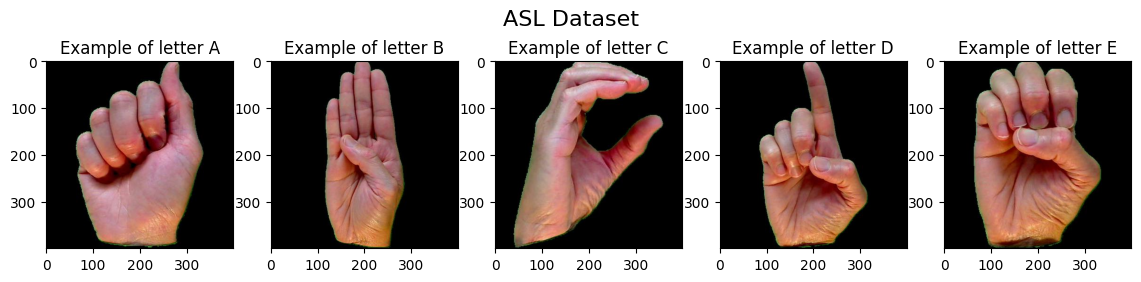

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(14, 3))
fig.suptitle('ASL Dataset', fontsize=16)

for ii, letter in enumerate(['A' , 'B', 'C', 'D', 'E']):
    dir = f'./asl_dataset/{letter}'
    img = tf.keras.preprocessing.image.load_img(dir+'/'+os.listdir(dir)[0])
    axes[ii].imshow(img)
    axes[ii].set_title(f'Example of letter {letter}')

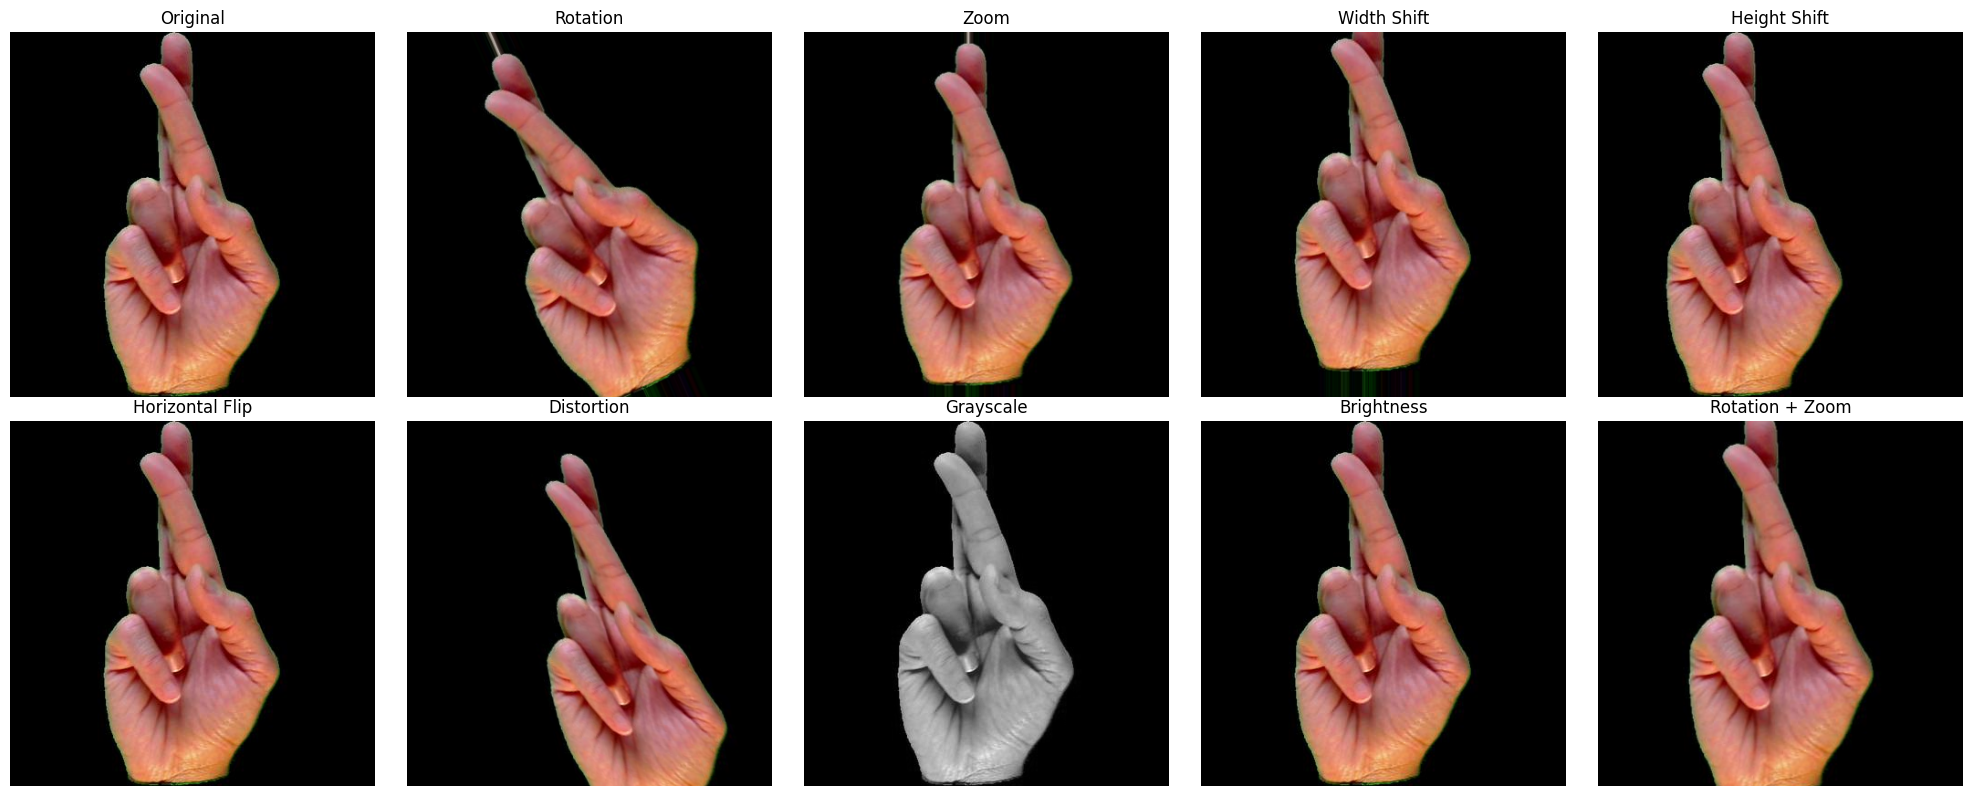

In [5]:
def visualize_all_augmentations(img_array):
    plt.figure(figsize=(20, 8))
    
    plt.subplot(2, 5, 1)
    plt.imshow(img_array[0].astype('uint8'))
    plt.title('Original')
    plt.axis('off')
    
    augmentations_row1 = [
        {'type': 'rotation_range', 'value': 40, 'title': 'Rotation'},
        {'type': 'zoom_range', 'value': 0.2, 'title': 'Zoom'},
        {'type': 'width_shift_range', 'value': 0.2, 'title': 'Width Shift'},
        {'type': 'height_shift_range', 'value': 0.2, 'title': 'Height Shift'}
    ]
    
    for i, aug in enumerate(augmentations_row1):
        datagen = ImageDataGenerator(**{aug['type']: aug['value']})
        aug_iter = datagen.flow(img_array, batch_size=1)
        plt.subplot(2, 5, i+2)
        batch = next(aug_iter)
        image = batch[0].astype('uint8')  
        plt.imshow(image)
        plt.title(aug['title'])
        plt.axis('off')
    
    datagen = ImageDataGenerator(horizontal_flip=True)
    aug_iter = datagen.flow(img_array, batch_size=1)
    plt.subplot(2, 5, 6)
    batch = next(aug_iter)
    image = batch[0].astype('uint8')
    plt.imshow(image)
    plt.title('Horizontal Flip')
    plt.axis('off')
    
    def apply_distortion(image):
        rows, cols = image.shape[:2]
        distortion = np.float32([
            [1, 0.2, 0],
            [0.2, 1, 0]
        ])
        dst = cv2.warpAffine(image, distortion, (cols, rows))
        return dst.astype('uint8')  

    plt.subplot(2, 5, 7)
    distorted_img = apply_distortion(img_array[0].astype('uint8'))
    plt.imshow(distorted_img)
    plt.title('Distortion')
    plt.axis('off')
    
    plt.subplot(2, 5, 8)
    gray_img = cv2.cvtColor(img_array[0].astype('uint8'), cv2.COLOR_RGB2GRAY)
    plt.imshow(gray_img, cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')
    
    datagen = ImageDataGenerator(brightness_range=[0.5, 1.5])
    aug_iter = datagen.flow(img_array, batch_size=1)
    plt.subplot(2, 5, 9)
    batch = next(aug_iter)
    image = batch[0].astype('uint8')
    plt.imshow(image)
    plt.title('Brightness')
    plt.axis('off')
    
    datagen = ImageDataGenerator(rotation_range=30, zoom_range=0.15)
    aug_iter = datagen.flow(img_array, batch_size=1)
    plt.subplot(2, 5, 10)
    batch = next(aug_iter)
    image = batch[0].astype('uint8')
    plt.imshow(image)
    plt.title('Rotation + Zoom')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

example_img_path = './asl_dataset/r/hand1_r_bot_seg_1_cropped.jpeg'
img = tf.keras.preprocessing.image.load_img(example_img_path)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

visualize_all_augmentations(img_array)

In [6]:
def train_val_datasets():
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2
    )
    
    train_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(64, 64),
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    validation_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(64, 64),
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
    
    return train_generator, validation_generator

train_generator, validation_generator = train_val_datasets()
print(f"Images of train dataset have shape: {train_generator.image_shape}")
print(f"Labels of train dataset have {train_generator.samples} samples and {train_generator.num_classes} classes")
print(f"Images of validation dataset have shape: {validation_generator.image_shape}")
print(f"Labels of validation dataset have {validation_generator.samples} samples and {validation_generator.num_classes} classes")

Found 2012 images belonging to 36 classes.
Found 503 images belonging to 36 classes.
Images of train dataset have shape: (64, 64, 3)
Labels of train dataset have 2012 samples and 36 classes
Images of validation dataset have shape: (64, 64, 3)
Labels of validation dataset have 503 samples and 36 classes


In [7]:
def create_model(learning_rate=0.0001, dropout_rate=0.5):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),  
        layers.Dense(36, activation='softmax')  
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),  
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = create_model()
model.summary()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688,740 (2.63 MB)

 Trainable params: 688,292 (2.63 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50  
)

In [ ]:
model.save('model/asl_cnn_model(3).h5')
model.save('model/asl_cnn_model(3).keras')

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


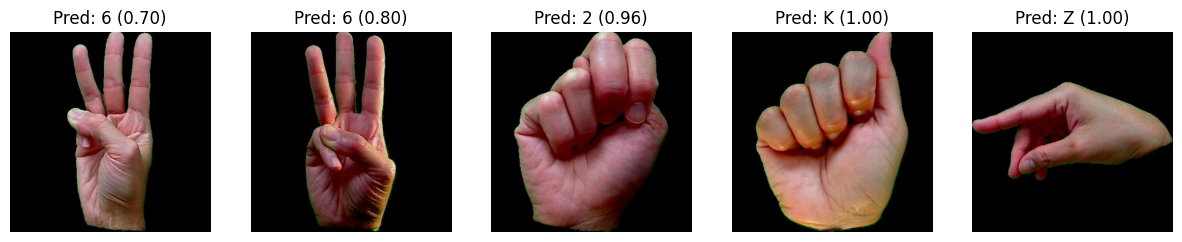

In [11]:
model_path = 'model/asl_cnn_model(1).h5'  
model = load_model(model_path)

class_labels = {i: chr(65 + i) for i in range(26)}  
class_labels.update({i+26: str(i) for i in range(10)})  

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (64, 64)) / 255.0
    img_array = np.expand_dims(img_resized, axis=0)
    return img_array, img

dataset_dir = 'asl_dataset/'
sample_images = []

for label_folder in os.listdir(dataset_dir):
    label_path = os.path.join(dataset_dir, label_folder)
    if os.path.isdir(label_path):
        sample_images.extend([
            os.path.join(label_path, img) for img in os.listdir(label_path)
            if img.endswith(('.jpg', '.jpeg', '.png'))
        ])

random_samples = random.sample(sample_images, 5)

plt.figure(figsize=(15, 6))
for idx, img_path in enumerate(random_samples):
    img_array, img = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])
    predicted_label = class_labels[predicted_index]
    confidence = predictions[0][predicted_index]

    plt.subplot(1, 5, idx + 1)
    plt.imshow(img)
    plt.title(f"Pred: {predicted_label} ({confidence:.2f})")
    plt.axis('off')

plt.show()